# pyPOD Tutorial
This module is a python library for rigorous and proper use of Proper Orthogonal Decomposition (or PCA) and its extensions developed in my dissertation.
The module will be available once the external defense is done (late August 2019).
This example is a demonstration of simplicity of use and performance of the method in Fluid Mechanics, but the module can be utilized with any PCA application, for the first parts, or time series data with non-linear dependencies.
The sequencing method was developed based on PCA, but further extension to auto-encoders is straight forward.

The module accepts any data structure, the only requirement is that the samples are in columns.
In this example, a scalar variable on a structured grid is shown as the synthetic case is easier to generate.
In case of unstructured grid, all the points will be in one single column.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyPOD
from scipy.signal import savgol_filter
from IPython.display import HTML
%matplotlib inline

## The Synthetic Data
The data can have many different shapes, but the main form should follow a few general rules.

grid: `grid = [variable,...]` for example, `x=grid[0], y=grid[1]`.

data: `u = [component,...,samples]` where the component part can be omitted for scalar data such as pressure.

The synthetic data is a gaussian distribution that moves around a circle randomly.

In [2]:
def smooth_noise(s=21, width=np.pi/36, seed=42):
    np.random.seed(seed)
    x = np.random.randint(0, 2, t.shape)*2-1
    x = x.cumsum()*width
    x = savgol_filter(x, s, 3)
    return x
ns = 1000
nx = 80
t=np.linspace(0, 2*np.pi, ns, endpoint=False)[None, None, :]
x=np.linspace(-7.5, 7.5, nx)
x,y=np.meshgrid(x, x)
grd = np.stack([x, y])

thetaw = smooth_noise(21)
y0 = 5*np.cos(20*thetaw) #+np.random.randn()
x0 = 5*np.sin(20*thetaw)
u = np.exp(-(x[:, :, None]-x0)**2-(y[:, :, None]-y0)**2)

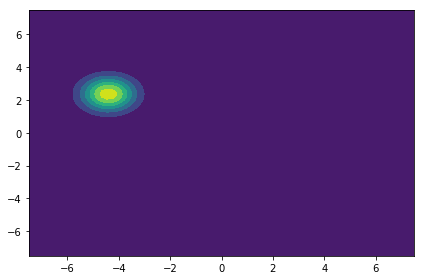

In [4]:
anim = pyPOD.plotting.animContourf(grd, u, inter=60);
HTML(anim.to_html5_video())

## POD Steps
The first step is to create a POD object.
Notice that call to the class only initiates the object, but does not solve the problem.
This is due to class inheritance for future developments into Incremental PCA.
To solve the problem, `solve` method should be called.
The Jacobian of the space should be provided for any spatially distributed dataset unless the data is on a uniform, Cartesian grid.

In [3]:
jac = np.ones_like(x)
pod = pyPOD.POD(u, jacobian=jac).solve()

Calculating the kernel.
Calculating eigen problem of right solution


Once the POD is solved, then the rule-N can be called to calculate desired cut-off numbers.
Rule-N (or Monte-Carlo) is a threshold for the modes (or dimensions) that are more structured than noise.
The caveat is that important information may be lost by a low-dimensional projection, given the units of the kernel are not properly chosen (the Jacobian of the space may contain density). 

The `print_value` is set to `False` by default, it just prints out the value of normalized cut-off which is compared with eigenvalues of the problem.

In [4]:
p50 = pod.ruleN(0.5, print_value=True)
p95 = pod.ruleN()
p100 = pod.ruleN(1.0)

The cut-off eigenvalue is 0.653


The energy content (normalized or absolute values) and their uncertainties can be retrieved easily

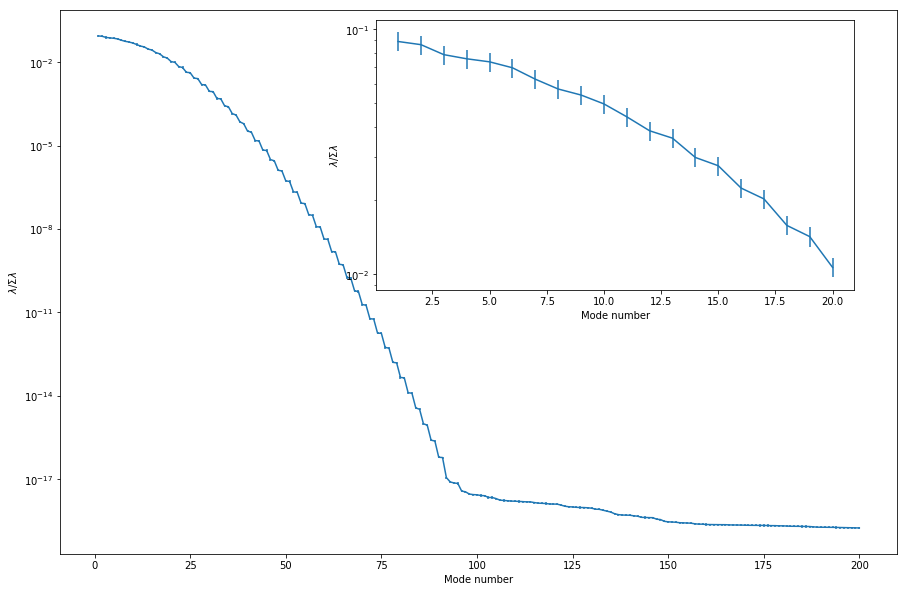

In [5]:
ev,evu = pod.energy(norm=True, uncertainty=True)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
f,ax0 = plt.subplots(figsize=(15,10))
ax0.errorbar(np.arange(200)+1, ev[:200], yerr=evu[:200])
ax0.set_yscale('log')
ax0.set_xlabel('Mode number')
ax0.set_ylabel('$\lambda/\Sigma\lambda$')
ax1 = inset_axes(ax0, '100%', '100%', bbox_to_anchor=[75, 10e-11, 125, 0.5], bbox_transform=ax0.transData)
ax1.errorbar(np.arange(20)+1, ev[:20], yerr=evu[:20])
ax1.set_xlabel('Mode number')
ax1.set_ylabel('$\lambda/\Sigma\lambda$')
ax1.set_yscale('log')

The desired range of modes can also be obtained easily, and in case of data on a 2D plane, plotted conveniently.
The dimension of output array is the same as the `inField`

inField shape:  (80, 80, 1000) Mode shapes:  (80, 80, 1000)


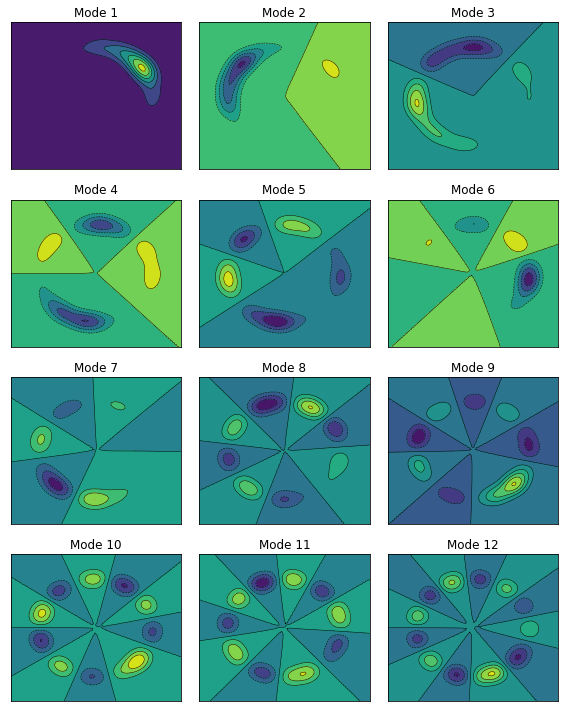

In [6]:
# All or part of the modes can be selected for plotting
efp = pod.modes()
print('inField shape: ', u.shape,'Mode shapes: ', efp.shape)
lbls = [f'Mode {i+1}' for i in range(12)]
f,axs = pyPOD.plotting.plotModes(grd, efp[...,:12], 4, lbls = lbls)

The global shape of the modes (dimensions), which is non-zero values across whole domain, is a main subject of this work.
The globality of the modes obscure the inter-modal interaction by increasing dependency between dimensions.

The degeneracy can be removed in one line.
However, it is not necessary to process all the modes.
Usually, correction up to `p50` is sufficient (unless the eigenvalue of the last dimension is not close to zero).

In [7]:
print('P50 =', p50)
ef_groups = pod.remove_degeneracy(p50)

P50 = 31
Calculating eigenvalue uncertainties
Calculating mode batches
Removing degeneracy within each group
Separating mode group 12/12


As the log shows 12 groups has been found in the first 31st modes.
The output of the function shows which modes has been processed together.

In [8]:
print(ef_groups)

[slice(0, 6, None), slice(6, 10, None), slice(10, 13, None), slice(13, 15, None), slice(15, 17, None), slice(17, 19, None), slice(19, 21, None), slice(21, 23, None), slice(23, 25, None), slice(25, 27, None), slice(27, 29, None), slice(29, 31, None)]


Now, corrected modes can be retrieved similar to original modes.
Since in python indexing starts at 0, it is easier to follow the same notation.

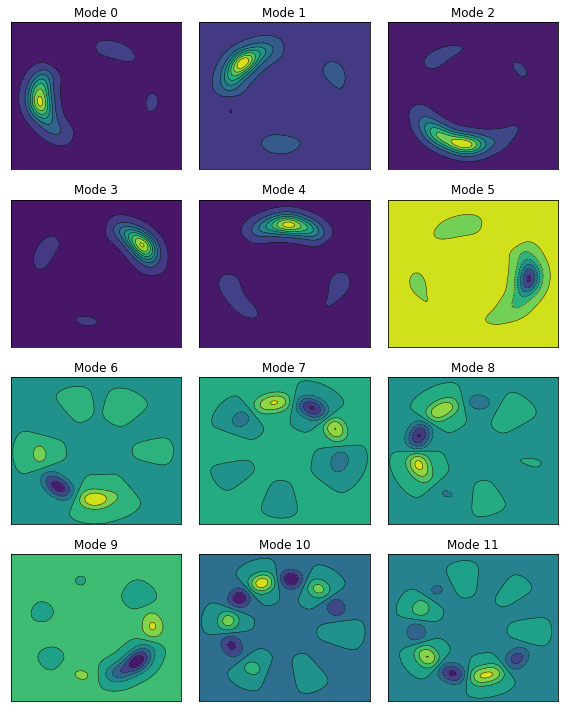

In [9]:
efp_ = pod.modes(corrected=True)
lbls = [f'Mode {i}' for i in range(12)]
pyPOD.plotting.plotModes(grd, efp_[...,:12], 4, lbls = lbls);

As the corrected modes show, the globality has been considerably reduced.
This makes it possible to pick fewer modes if only parts of the domain is of interest.
Moreover, if two parts of the domain have similar but independent dynamics, the modal correction separates them rightfully.

The traveling waves (non-linear interaction of the modes) can be obtained from original or corrected modes.
First, the coefficients should be extracted from `pod` object.

In [10]:
fc_o = pyPOD.utilities.frequency_criteria(pod.coefs[:p50])
fc_c = pyPOD.utilities.frequency_criteria(pod.coefs_[:p50])
dc_o = pyPOD.utilities.derivative_criteria(pod.coefs[:p50])
dc_c = pyPOD.utilities.derivative_criteria(pod.coefs_[:p50])

The criteria could be shown using `imshow`.

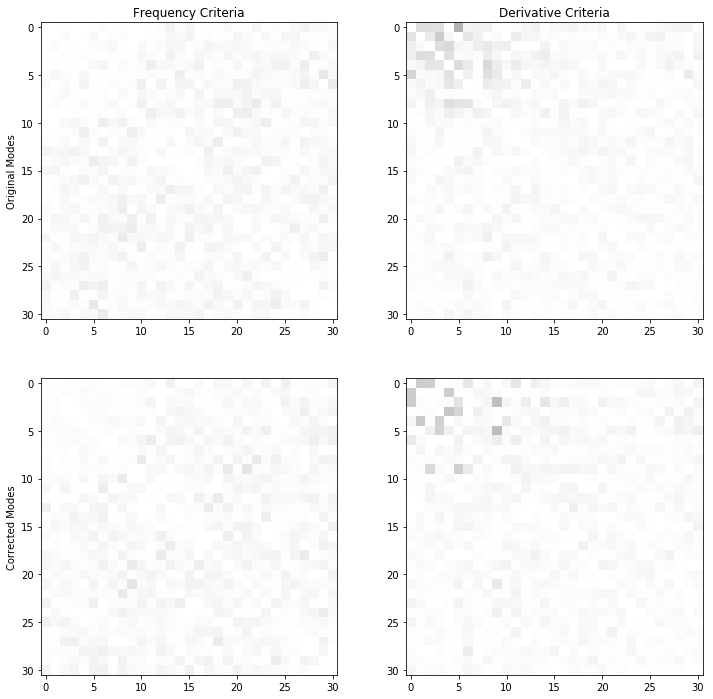

In [11]:
def show_tw(tw,ax):
    ax.imshow(tw, cmap = plt.cm.gray_r, vmin = 0, vmax = 1)
f,axs = plt.subplots(2, 2, figsize=(12,12))
show_tw(np.abs(fc_o), axs[0,0])
show_tw(np.abs(fc_c), axs[1,0])
show_tw(dc_o, axs[0,1])
show_tw(dc_c, axs[1,1])
axs[0,0].set_title('Frequency Criteria')
axs[0,1].set_title('Derivative Criteria')
axs[0,0].set_ylabel('Original Modes')
axs[1,0].set_ylabel('Corrected Modes');

The frequency criteria extracts the multi-lag spectral Granger-Causality. 
As the associaiton map shows, this approach is not capable of capturing some interactions but the Derivative Criteria unveils them.
Moreover, the limited and pronounced associations from the corrected modes shows the importance of Modal Correction.

Another measure that was developed in my thesis is Energy-Ratio.
The ER is to find samples where a dimension is salient.
A main objective of this measure is to find low-energy dimensions which have intermittent but strong exposure in some samples.

To calculate the ER, the groups of modes which interact with each other should be found first.
There are many different ways to look for the traveling wave groups.
The function can look for only mutual values, can return the association level, all non-unique groups, etc.
For a full list see the documentation.
The threshold should be set, since the maximum association is 0.26 (9,5), all associations higher than 0.1 are searched.

In [31]:
a_groups = pyPOD.utilities.associated_groups(dc_c, min_association=0.1, return_levels=True)
for a_list, a_values in a_groups:
    print('Modes', a_list, 'have associations', np.round(a_values,3))

Modes [0, 1, 4, 3, 5, 9, 2] have associations [0.199 0.213 0.224 0.172 0.185 0.251]


In [18]:
np.round(dc_c[:11,:11],2)

array([[0.  , 0.2 , 0.19, 0.  , 0.01, 0.01, 0.09, 0.01, 0.03, 0.  , 0.03],
       [0.2 , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.01, 0.04, 0.03, 0.02, 0.  ],
       [0.2 , 0.02, 0.  , 0.01, 0.01, 0.11, 0.01, 0.02, 0.04, 0.25, 0.04],
       [0.  , 0.01, 0.01, 0.  , 0.22, 0.16, 0.  , 0.06, 0.02, 0.01, 0.01],
       [0.04, 0.21, 0.  , 0.19, 0.  , 0.03, 0.01, 0.03, 0.02, 0.01, 0.09],
       [0.01, 0.  , 0.06, 0.17, 0.06, 0.  , 0.05, 0.04, 0.03, 0.26, 0.02],
       [0.08, 0.02, 0.  , 0.  , 0.  , 0.05, 0.  , 0.02, 0.03, 0.07, 0.02],
       [0.  , 0.04, 0.  , 0.04, 0.02, 0.04, 0.02, 0.  , 0.02, 0.01, 0.01],
       [0.02, 0.01, 0.01, 0.  , 0.03, 0.02, 0.  , 0.05, 0.  , 0.02, 0.05],
       [0.01, 0.01, 0.15, 0.02, 0.01, 0.19, 0.08, 0.  , 0.02, 0.  , 0.01],
       [0.  , 0.01, 0.  , 0.01, 0.04, 0.01, 0.  , 0.01, 0.02, 0.  , 0.  ]])

Plotting the mentioned modes shows the rotational behavior of the system.

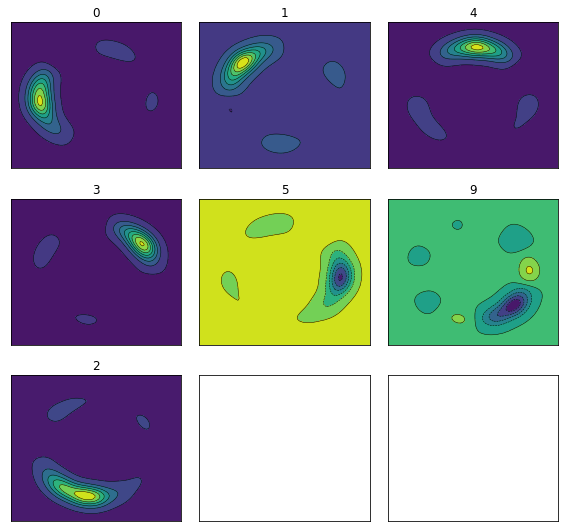

In [34]:
pyPOD.plotting.plotModes(grd, efp_[..., a_groups[0][0]], 3, lbls=a_groups[0][0]);

Since the chain association lead to a single group, energy ratio of that group can be illustrated with a line.

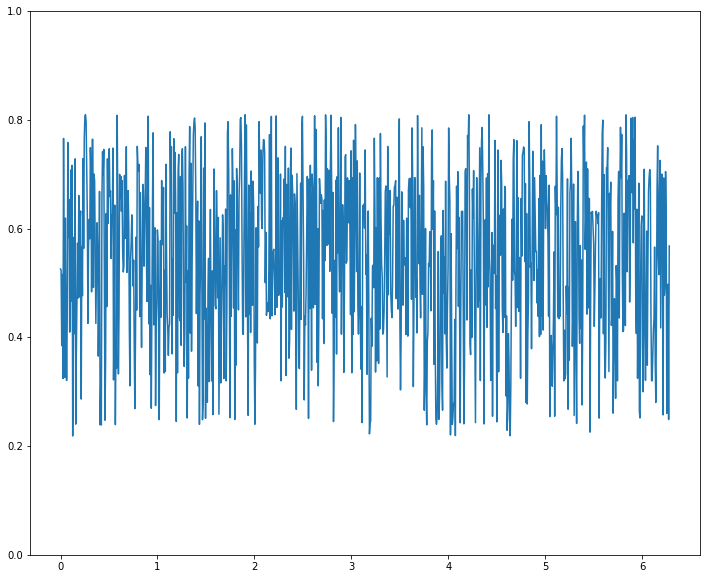

In [27]:
er = pyPOD.utilities.energy_ratio(pod.coefs_, a_groups[0][0])
plt.figure(figsize=(12,10))
plt.plot(t[0,0], er)
plt.ylim([0,1]);

The Sequencing Method (which is not presented here), takes advantage of the low-dimensional projection of the manifold that presents the data to generate most likely time-resolved sequences from a non-time-resolved dataset.